In [1]:
!sudo apt install -y fluidsynth

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin
  libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5
  libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libxcb-icccm4 libxcb-image0 libxcb-keysyms1
  libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1
  libxkbcommon-x11-0 qsynth qt5-gtk-platformtheme qttranslations5-l10n
  timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs qt5-image-formats-plugins qtwayland5 jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libevdev2 libfluidsynth3 libgudev-1.0-0
  libinput-bin libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a
  libqt5dbus5 libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libx

In [2]:
!pip install --upgrade pyfluidsynth

  Preparing metadata (setup.py) ... done
  Created wheel for pyfluidsynth: filename=pyFluidSynth-1.3.3-py3-none-any.whl size=19185 sha256=70b1ac0e70070ef0f6aa0bcf28984cd68eda239f583e7213325be3660be4d092
  Stored in directory: /root/.cache/pip/wheels/e6/9c/2b/b4b194cbb100d6f20136a22b2f76cd329b1a21139ed26c9775
Successfully built pyfluidsynth


In [3]:
!pip install pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 26.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 1.5 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592289 sha256=7b71b50577f22c591ca5be139eb3fdbc5175b9d6cde9d15519e81f4b5cc031d2
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1


In [4]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

In [5]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

59243107/59243107 [==============================] - 1s 0us/step


In [6]:
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1282


In [7]:
sample_file = filenames[1]
print(sample_file)

data/maestro-v2.0.0/2009/MIDI-Unprocessed_07_R2_2009_01_ORIG_MID--AUDIO_07_R2_2009_07_R2_2009_01_WAV.midi


In [8]:
pm = pretty_midi.PrettyMIDI(sample_file)

In [9]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [10]:
display_audio(pm)

In [11]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


In [12]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=51, note_name=D#3, duration=1.4805
1: pitch=55, note_name=G3, duration=1.4818
2: pitch=60, note_name=C4, duration=1.4935
3: pitch=48, note_name=C3, duration=1.4961
4: pitch=36, note_name=C2, duration=1.5169
5: pitch=51, note_name=D#3, duration=0.0365
6: pitch=60, note_name=C4, duration=0.0443
7: pitch=48, note_name=C3, duration=0.0339
8: pitch=36, note_name=C2, duration=0.0430
9: pitch=48, note_name=C3, duration=0.0469


In [13]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [14]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

pitch     start       end      step  duration
0     60  0.968750  2.462240  0.000000  1.493490
1     51  0.970052  2.450521  0.001302  1.480469
2     48  0.971354  2.467448  0.001302  1.496094
3     36  0.972656  2.489583  0.001302  1.516927
4     55  0.979167  2.460938  0.006510  1.481771

In [15]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['C4', 'D#3', 'C3', 'C2', 'G3', 'D#3', 'C4', 'C3', 'C2', 'G#3'],
      dtype='<U3')

In [16]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str,
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [17]:
num_files = 5
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [18]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 23410


In [19]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [20]:
print(train_notes[:10])

[[4.50000000e+01 0.00000000e+00 4.42708333e-02]
 [5.70000000e+01 1.30208333e-03 4.03645833e-02]
 [6.20000000e+01 1.86197917e-01 4.03645833e-02]
 [5.00000000e+01 1.04166667e-02 3.77604167e-02]
 [5.70000000e+01 1.78385417e-01 4.94791667e-02]
 [4.50000000e+01 2.60416667e-03 5.20833333e-02]
 [6.20000000e+01 1.82291667e-01 3.38541667e-02]
 [5.00000000e+01 1.30208333e-03 3.38541667e-02]
 [5.40000000e+01 1.78385417e-01 3.51562500e-02]
 [6.60000000e+01 1.30208333e-03 4.03645833e-02]]


In [21]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [22]:
def create_sequences(
    dataset: tf.data.Dataset,
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [23]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [24]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.3515625  0.         0.04427083]
 [0.4453125  0.00130208 0.04036458]
 [0.484375   0.18619792 0.04036458]
 [0.390625   0.01041667 0.03776042]
 [0.4453125  0.17838542 0.04947917]
 [0.3515625  0.00260417 0.05208333]
 [0.484375   0.18229167 0.03385417]
 [0.390625   0.00130208 0.03385417]
 [0.421875   0.17838542 0.03515625]
 [0.515625   0.00130208 0.04036458]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=73.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.06640625>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.07942708333333304>}


In [25]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [26]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

In [27]:
import numpy as np
import librosa
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Reshape, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

In [56]:
######## VAE ############

input_shape = (seq_length, 3)
learning_rate = 0.005
latent_dim = 2
n_mels = 25
time_frames = 3

# Encoder
encoder_input = Input(shape=input_shape)
encoder_flatten = Flatten()(encoder_input)
z_mean = Dense(latent_dim)(encoder_flatten)
z_log_var = Dense(latent_dim)(encoder_flatten)

def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
encoder = Model(encoder_input, [z_mean, z_log_var, z], name="encoder")

# Decoder
decoder_input = Input(shape=(latent_dim,))
x = Dense(n_mels * time_frames, activation="sigmoid")(decoder_input)
outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
  'decoder_reshaped': Reshape((n_mels, time_frames))(x)
}

decoder = Model(decoder_input, outputs, name="decoder")

In [57]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [61]:
encoder_output = encoder(encoder_input)
decoder_output = decoder(encoder_output[2])

In [62]:
from tensorflow.keras.losses import mse

outputs = {
    'pitch': decoder_output['pitch'],
    'step': decoder_output['step'],
    'duration': decoder_output['duration'],
    'decoder_reshaped': decoder_output['decoder_reshaped']
}
vae = Model(inputs=encoder_input, outputs=outputs, name='vae')

reconstruction_loss = mse(encoder_input, outputs['decoder_reshaped'])
reconstruction_loss *= input_shape[0] * input_shape[1]
kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
kl_loss = tf.reduce_mean(kl_loss) * -0.5
vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

# loss = {
#       'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
#           from_logits=True),
#       'step': mse_with_positive_pressure,
#       'duration': mse_with_positive_pressure,
#       'decoder_reshaped': 'mse',
# }


# Compile the VAE
vae.compile(
    optimizer=Adam(learning_rate=0.001)
    # loss=loss,
    # loss_weights={
    #   'pitch': 0.05,
    #   'step': 1.0,
    #   'duration':1.0,
    #   'decoder_reshaped': 1.0,
    # }
  )
vae.summary()
# Train the VAE
# history = vae.fit([audio_data, audio_data], [audio_data, np.zeros_like(audio_data)],
#                   epochs=100,
#                   batch_size=batch_size)

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 25, 3)]              0         []                            
                                                                                                  
 encoder (Functional)        [(None, 2),                  304       ['input_3[0][0]']             
                              (None, 2),                                                          
                              (None, 2)]                                                          
                                                                                                  
 decoder (Functional)        {'pitch': (None, 128),       10105     ['encoder[1][2]']             
                              'step': (None, 1),                                                

In [63]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [64]:
epochs = 50

history = vae.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50


365/365 [==============================] - 2s 3ms/step - loss: 8.5579
Epoch 2/50
365/365 [==============================] - 1s 2ms/step - loss: 6.2123
Epoch 3/50
365/365 [==============================] - 1s 4ms/step - loss: 5.7673
Epoch 4/50
365/365 [==============================] - 1s 2ms/step - loss: 5.5236
Epoch 5/50
365/365 [==============================] - 1s 3ms/step - loss: 5.3761
Epoch 6/50
365/365 [==============================] - 1s 3ms/step - loss: 5.2515
Epoch 7/50
365/365 [==============================] - 1s 2ms/step - loss: 5.1583
Epoch 8/50
365/365 [==============================] - 1s 2ms/step - loss: 5.0656
Epoch 9/50
365/365 [==============================] - 1s 3ms/step - loss: 4.9838
Epoch 10/50
365/365 [==============================] - 1s 4ms/step - loss: 4.9271
Epoch 11/50
365/365 [==============================] - 1s 2ms/step - loss: 4.8851
Epoch 12/50
365/365 [==============================] - 1s 2ms/step - loss: 4.8475
Epoch 13/50
365/365 [===============

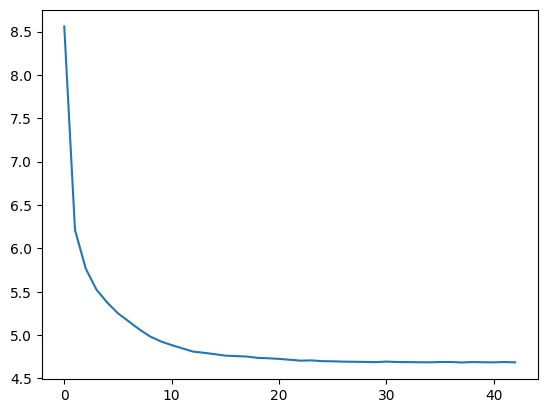

In [65]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [66]:
def predict_next_note(
    notes: np.ndarray,
    model: tf.keras.Model,
    temperature: float = 1.0) -> tuple[int, float, float]:
  """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [67]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, vae, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 [==============================] - 0s 21ms/step


In [68]:
generated_notes.head(10)

pitch      step  duration     start       end
0     14  0.000000  0.168414  0.000000  0.168414
1     37  0.000000  0.227041  0.000000  0.227041
2    118  0.000000  0.000000  0.000000  0.000000
3     78  0.055662  0.627278  0.055662  0.682940
4     72  0.141246  0.211248  0.196909  0.408157
5     93  0.274738  0.262764  0.471647  0.734411
6     89  0.370261  0.797662  0.841908  1.639570
7    109  0.371296  0.632244  1.213205  1.845449
8      7  0.119714  0.801662  1.332918  2.134580
9     31  0.092278  1.588136  1.425197  3.013333

In [69]:
out_file = 'dense_output2.midi'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

In [70]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

seq_start = 1000
# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[seq_start:seq_length + seq_start] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, vae, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 [==============================] - 0s 40ms/step


In [71]:
out_file = 'dense_output3.midi'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

In [72]:
######## VAE LSTM ############
from tensorflow.keras.layers import Input, Dense, Lambda, LSTM, RepeatVector, TimeDistributed

input_shape = (seq_length, 3)
learning_rate = 0.005
latent_dim = 2

# Encoder
encoder_input = Input(shape=input_shape)
x = LSTM(128, return_sequences=True)(encoder_input)
x = LSTM(64)(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
encoder = Model(encoder_input, [z_mean, z_log_var, z], name="encoder")

# Decoder
decoder_input = Input(shape=(latent_dim,))
x = RepeatVector(input_shape[0])(decoder_input)
x = LSTM(64, return_sequences=True)(x)
x = LSTM(128, return_sequences=True)(x)
x = TimeDistributed(Dense(3))(x)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
  'decoder_reshaped': Reshape((input_shape[0], input_shape[1]))(x)
}

# decoder_input = Input(shape=(latent_dim,))
# x = Dense(n_mels * time_frames, activation="sigmoid")(decoder_input)
# outputs = {
#   'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
#   'step': tf.keras.layers.Dense(1, name='step')(x),
#   'duration': tf.keras.layers.Dense(1, name='duration')(x),
#   'decoder_reshaped': Reshape((n_mels, time_frames))(x)
# }
# x = Flatten()(x)
# o1 = TimeDistributed(Dense(128, name='pitch'))(x)
# o2 = TimeDistributed(Dense(1, name='step'))(x)
# o3 = TimeDistributed(Dense(1, name='duration'))(x)
# o4 = TimeDistributed(Dense(3))(x)

# o1 = Flatten()(o1)
# o2 = Flatten()(o2)
# o3 = Flatten()(o3)
# o4 = Flatten()(o4)

# o1 = Dense(128)(o1)
# o2 = Dense(1)(o2)
# o3 = Dense(1)(o3)
# o4 = Reshape((n_mels, time_frames))(o4)

# outputs = {
#     'pitch': o1,
#     'step': o2,
#     'duration': o3,
#     'decoder_reshaped': o4
# }
# x = Dense(n_mels * time_frames, activation="sigmoid")(decoder_input)
# partial = TimeDistributed(Dense(3))(x)
# outputs = {
#   'pitch': TimeDistributed(Dense(128, name='pitch'))(x),
#   'step': TimeDistributed(Dense(1, name='step'))(x),
#   'duration': TimeDistributed(Dense(1, name='duration'))(x),
#   'decoder_reshaped': Reshape((n_mels, time_frames))(partial)
# }
# outputs = {
#   'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
#   'step': tf.keras.layers.Dense(1, name='step')(x),
#   'duration': tf.keras.layers.Dense(1, name='duration')(x),
#   'decoder_reshaped': Reshape((n_mels, time_frames))(x)
# }

decoder = Model(decoder_input, outputs, name="decoder")
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 2)]                  0         []                            
                                                                                                  
 repeat_vector (RepeatVecto  (None, 25, 2)                0         ['input_6[0][0]']             
 r)                                                                                               
                                                                                                  
 lstm_2 (LSTM)               (None, 25, 64)               17152     ['repeat_vector[0][0]']       
                                                                                                  
 lstm_3 (LSTM)               (None, 25, 128)              98816     ['lstm_2[0][0]']        

In [73]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [74]:
encoder_output = encoder(encoder_input)
decoder_output = decoder(encoder_output[2])

In [77]:
from tensorflow.keras.losses import mse

outputs = {
    'pitch': decoder_output['pitch'],
    'step': decoder_output['step'],
    'duration': decoder_output['duration'],
    'decoder_reshaped': decoder_output['decoder_reshaped']
}
vae2 = Model(inputs=encoder_input, outputs=outputs, name='vae2')

reconstruction_loss = mse(encoder_input, outputs['decoder_reshaped'])
reconstruction_loss *= input_shape[0] * input_shape[1]
kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
kl_loss = tf.reduce_mean(kl_loss) * -0.5
vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
vae2.add_loss(vae_loss)



vae2.compile(
    optimizer=Adam(learning_rate=0.001)
    # loss=loss,
    # loss_weights={
    #   'pitch': 0.05,
    #   'step': 1.0,
    #   'duration':1.0,
    #   'decoder_reshaped': 1.0,
    # }
  )
vae2.summary()

Model: "vae2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 25, 3)]              0         []                            
                                                                                                  
 encoder (Functional)        [(None, 2),                  117252    ['input_5[0][0]']             
                              (None, 2),                                                          
                              (None, 2)]                                                          
                                                                                                  
 decoder (Functional)        {'pitch': (None, 25, 128),   116875    ['encoder[0][2]']             
                              'step': (None, 25, 1),                                           

In [78]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

epochs = 50

history = vae2.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50


365/365 [==============================] - 87s 200ms/step - loss: 4.9725
Epoch 2/50
365/365 [==============================] - 75s 205ms/step - loss: 4.5459
Epoch 3/50
365/365 [==============================] - 72s 198ms/step - loss: 4.4541
Epoch 4/50
365/365 [==============================] - 73s 201ms/step - loss: 4.3692
Epoch 5/50
365/365 [==============================] - 75s 205ms/step - loss: 4.3480
Epoch 6/50
365/365 [==============================] - 73s 200ms/step - loss: 4.2989
Epoch 7/50
365/365 [==============================] - 71s 195ms/step - loss: 4.2743
Epoch 8/50
365/365 [==============================] - 73s 201ms/step - loss: 4.2430
Epoch 9/50
365/365 [==============================] - 72s 198ms/step - loss: 4.2428
Epoch 10/50
365/365 [==============================] - 80s 219ms/step - loss: 4.2332
Epoch 11/50
365/365 [==============================] - 79s 215ms/step - loss: 4.2124
Epoch 12/50
365/365 [==============================] - 74s 202ms/step - loss: 4.2195


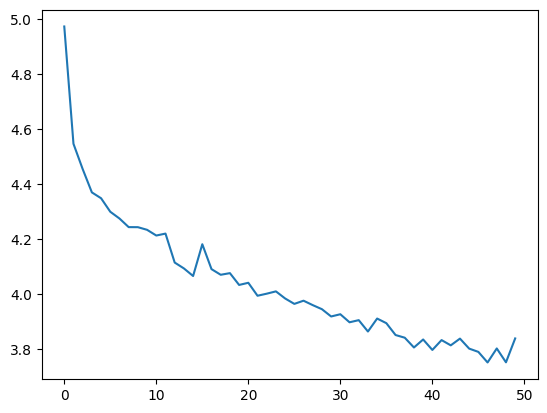

In [79]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

# Model dalej sie poprawia więc jeszcze go doucze

In [88]:
history2 = vae2.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
365/365 [==============================] - 80s 220ms/step - loss: 3.7613
Epoch 2/50
365/365 [==============================] - 77s 211ms/step - loss: 3.7662
Epoch 3/50
365/365 [==============================] - 76s 207ms/step - loss: 3.7434
Epoch 4/50
365/365 [==============================] - 73s 202ms/step - loss: 3.7732
Epoch 5/50
365/365 [==============================] - 71s 195ms/step - loss: 3.9019
Epoch 6/50
365/365 [==============================] - 75s 207ms/step - loss: 3.8225
Epoch 7/50
365/365 [==============================] - 73s 200ms/step - loss: 3.7858
Epoch 8/50
365/365 [==============================] - 72s 196ms/step - loss: 3.7621
Epoch 8: early stopping


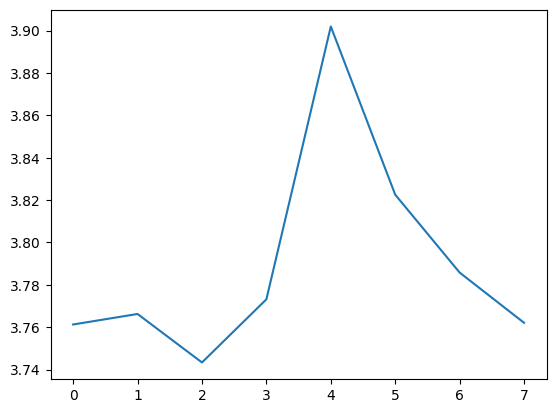

In [89]:
plt.plot(history2.epoch, history2.history['loss'], label='total loss')
plt.show()

In [94]:
def predict_next_note(
    notes: np.ndarray,
    model: tf.keras.Model,
    temperature: float = 1.0) -> tuple[int, float, float]:
  """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch_logits = tf.squeeze(pitch_logits, axis=0)
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)[-1]
  duration = tf.squeeze(duration, axis=-1)
  duration = tf.squeeze(duration, axis=0)[-1]
  step = tf.squeeze(step, axis=-1)
  step = tf.squeeze(step, axis=0)[-1]

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [95]:
temperature = 2
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, vae2, temperature)
  # step= np.random.uniform(0.35, 0.55)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 [==============================] - 0s 65ms/step


In [96]:
generated_notes[:10]

pitch      step  duration     start       end
0     32  0.241910  0.040985  0.241910  0.282896
1    112  0.275551  0.085720  0.517461  0.603182
2     27  0.265192  0.072741  0.782654  0.855394
3      7  0.037572  0.000000  0.820226  0.820226
4     91  0.183823  0.000000  1.004049  1.004049
5     49  0.145306  0.000000  1.149355  1.149355
6    117  0.025706  0.000000  1.175061  1.175061
7     34  0.049452  0.000000  1.224514  1.224514
8    123  0.025790  0.000000  1.250303  1.250303
9    104  0.042985  0.000000  1.293289  1.293289

In [97]:
out_file = 'lstm_output_no_step_cheat.midi'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

In [76]:
from google.colab import drive
drive.mount('/drive')


Mounted at /drive


In [98]:
vae2.save_weights('/drive/My Drive/GGSN/models/vae_lstm_music', save_format="h5")